# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

### План 3 недели:
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as f:
        sites_freq = pickle.load(f)
    sites_ids = {key: id+1 for id,key in enumerate(sites_freq.keys())}
    files = sorted(glob(path_to_csv_files+'/*.csv'))
    n_files = len(files)
    data_sites = pd.DataFrame(columns = feature_names)
    for k in range(n_files):
        user_data = pd.read_csv(files[k])
        sites_1 = user_data['site'].map(sites_ids).values
        n_sites = len(sites_1)
        n_sessions = (n_sites-1)//window_size + 1
        add_length = (n_sessions-1)*window_size + session_length - n_sites
        sites_2 = np.append(sites_1, np.zeros((1, add_length), dtype = int))
        sites_array = np.array([sites_2[i+j] for i in range(0,n_sessions*window_size,window_size) 
                                for j in range(session_length)]).reshape((n_sessions,session_length))
        times = pd.to_datetime(user_data['timestamp'])
        diff_times = np.zeros((n_sessions,session_length-1), dtype = int)
        for i in range(n_sessions-1):
            start = window_size*i
            finish = start + session_length
            session_times = np.array([times[j] for j in range(start,finish)])
            if len(session_times) > 1:
                diff_times[i//window_size,:] = pd.Series(session_times[1:]-session_times[:-1]).dt.total_seconds()
        start = window_size*(n_sessions-1)
        session_times = np.array([times[j] for j in range(start,n_sites)])
        if len(session_times) > 1:
            diff_times[n_sessions-1,:n_sites-start-1] = pd.Series(session_times[1:]-session_times[:-1]).dt.total_seconds()
        times = pd.concat([times, pd.Series(np.tile(times[len(times)-1],add_length))], ignore_index=True)
        if add_length > 0:
            sites_2[-add_length:] = sites_1[-1]*np.ones((1,add_length), dtype = int)
        df = pd.DataFrame(np.hstack((sites_array,diff_times)), columns = feature_names[:-5])
        df['session_timespan'] = np.array([int((max(times[i:i+session_length])-min(times[i:i+session_length])).total_seconds()) 
                                           for i in range(0,n_sessions*window_size,window_size)])
        df['#unique_sites'] = np.array([len(np.unique(sites_2[i:i+session_length])) 
                                        for i in range(0,n_sessions*window_size,window_size)])
        df['start_hour'] = np.array([min(times[i:i+session_length]).hour for i in range(0,n_sessions*window_size,window_size)])
        df['day_of_week'] = np.array([min(times[i:i+session_length]).weekday() 
                                      for i in range(0,n_sessions*window_size,window_size)])
        df['target'] = np.array([int(files[k][-8:-4])]*df.shape[0])
        data_sites = data_sites.append(df, ignore_index = True)
    
    return data_sites

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
train_data_toy = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA,'3users'), 
                                           os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'),
                                           feature_names = feature_names, session_length = 10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
import time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA,'10users'), 
                                               os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 
                                               feature_names = feature_names, session_length = 10)

Wall time: 21.9 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,3,0,1,0,1,1,1,2,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,0,0,1,15,0,1,0,0,1,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,1,0,0,0,1,1,0,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,1,1,1,0,5,1,3,13,2,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,1,0,0,0,1,0,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA,'150users'), 
                                                os.path.join(PATH_TO_DATA,'site_freq_150users.pkl'), 
                                                feature_names = feature_names, session_length = 10)

Wall time: 3min 50s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [10]:
with open(os.path.join(PATH_TO_DATA,'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA,'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [11]:
print('Медианная продолжительность сессии: %d секунд' % np.median(train_data_10users['session_timespan']))

Медианная продолжительность сессии: 37 секунд


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [12]:
print('Медианный день недели: %d' % np.median(train_data_10users['day_of_week']))

Медианный день недели: 2


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [13]:
print('Медианный час начала сессии: %d часов' % np.median(train_data_150users['start_hour']))

Медианный час начала сессии: 13 часов


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [14]:
print('Медианное значение числа уникальных сайтов: %d' % np.median(train_data_150users['#unique_sites']))

Медианное значение числа уникальных сайтов: 7


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

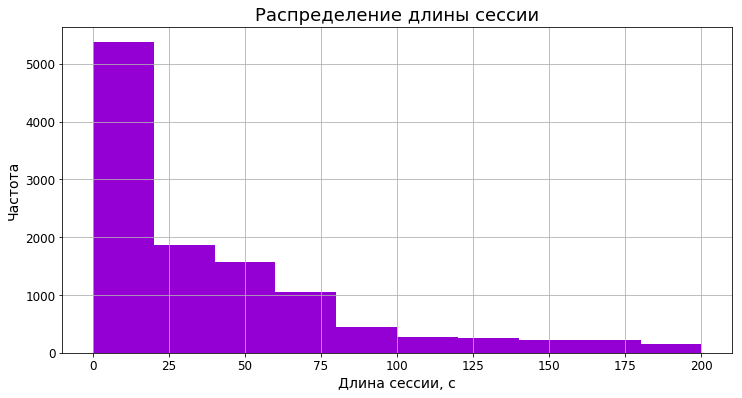

In [17]:
plt.figure(figsize = (12,6))
n, bins, patches = plt.hist([elem for elem in train_data_10users['session_timespan'] if elem <= 200], color = 'darkviolet')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Длина сессии, с', fontsize = 14)
plt.ylabel('Частота', fontsize = 14)
plt.title('Распределение длины сессии', fontsize = 18)
plt.grid(True)
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

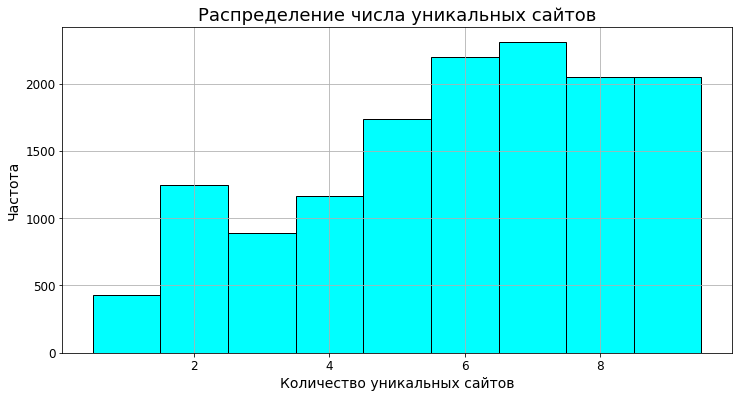

In [18]:
plt.figure(figsize = (12,6))
data = [elem for elem in train_data_10users['#unique_sites']]
n, bins, patches = plt.hist(data, bins = list(range(min(data),max(data)+1)), color = 'aqua', edgecolor='black', align = 'left')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Количество уникальных сайтов', fontsize = 14)
plt.ylabel('Частота', fontsize = 14)
plt.title('Распределение числа уникальных сайтов', fontsize = 18)
plt.grid(True)
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

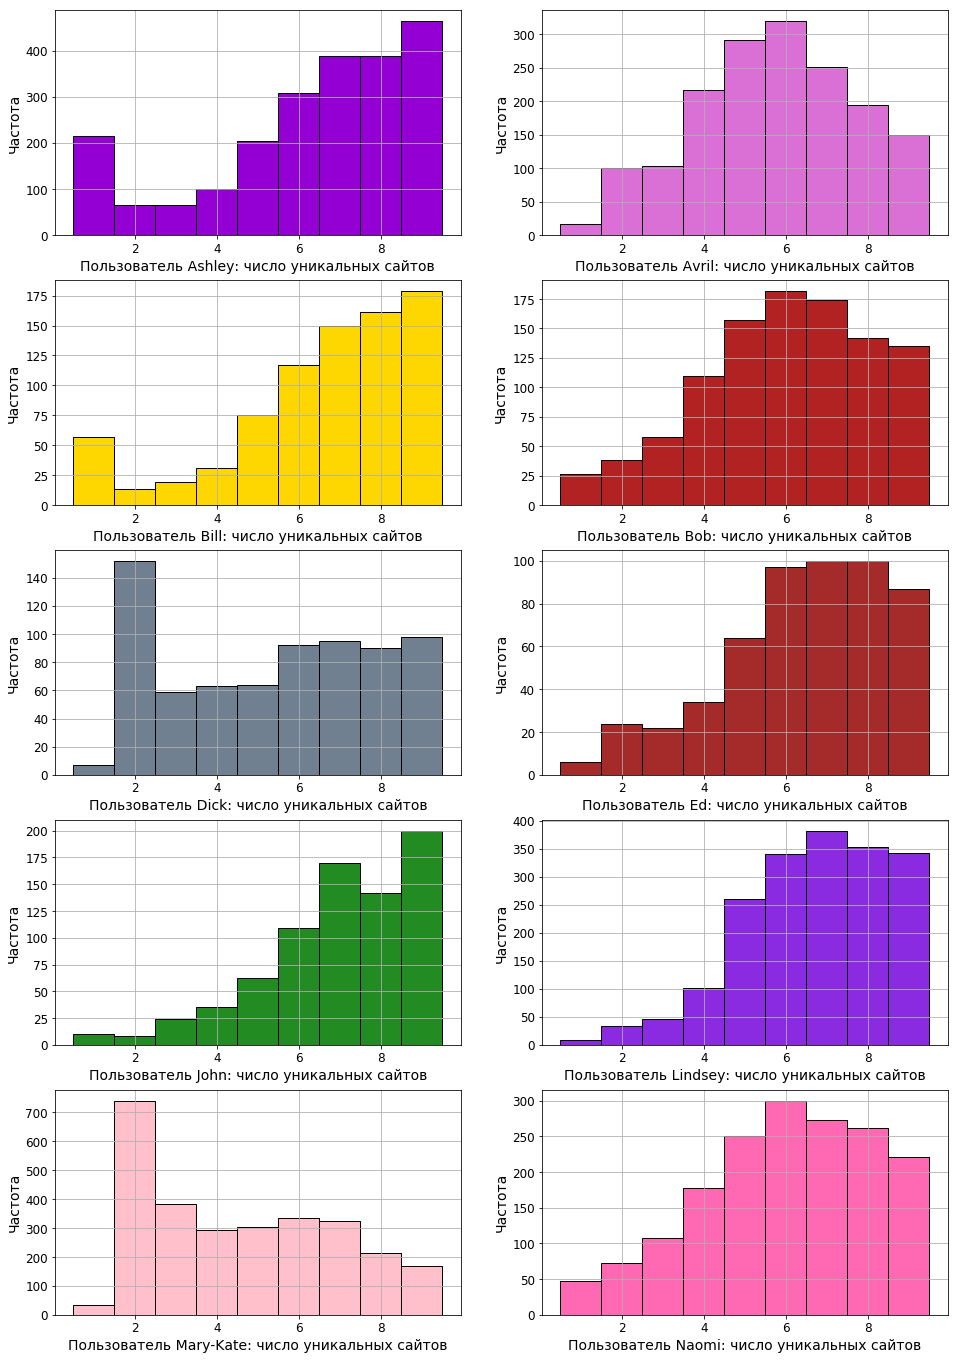

In [19]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (16, 24))
for idx, (user, sub_df) in enumerate(pd.groupby(train_data_10users, 'target')): 
    data = [elem for elem in sub_df['#unique_sites']]
    plt.subplot(5,2,idx+1)
    plt.hist(data, bins = list(range(min(data),max(data)+1)), color = color_dic[user], edgecolor='black', align = 'left')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Пользователь ' + user + ': число уникальных сайтов', fontsize = 14)
    plt.ylabel('Частота', fontsize = 14)
    plt.grid(True)

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

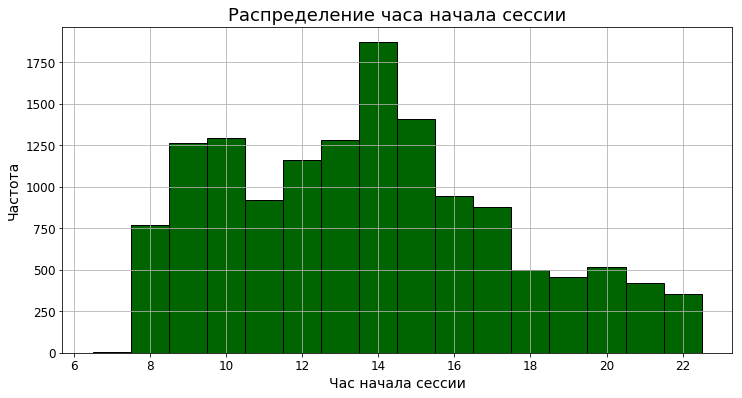

In [20]:
plt.figure(figsize = (12,6))
data = [elem for elem in train_data_10users['start_hour']]
n, bins, patches = plt.hist(data, bins = list(range(min(data),max(data)+1)), color = 'darkgreen', 
                            edgecolor='black', align = 'left')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Час начала сессии', fontsize = 14)
plt.ylabel('Частота', fontsize = 14)
plt.title('Распределение часа начала сессии', fontsize = 18)
plt.grid(True)
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

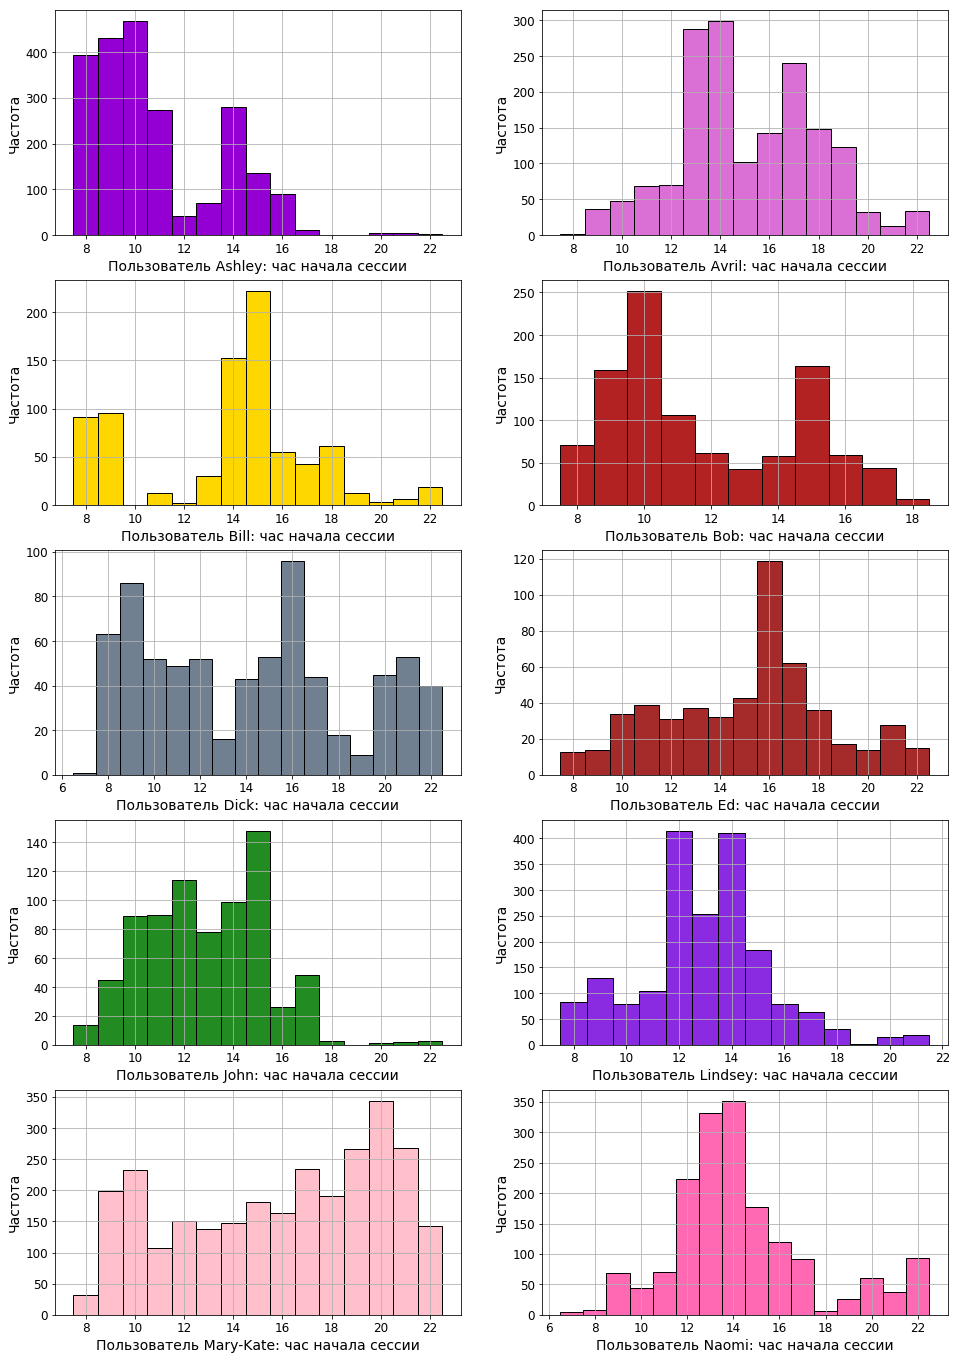

In [21]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (16, 24))
for idx, (user, sub_df) in enumerate(pd.groupby(train_data_10users, 'target')): 
    data = [elem for elem in sub_df['start_hour']]
    plt.subplot(5,2,idx+1)
    plt.hist(data, bins = list(range(min(data),max(data)+1)), color = color_dic[user], edgecolor='black', align = 'left')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Пользователь ' + user + ': час начала сессии', fontsize = 14)
    plt.ylabel('Частота', fontsize = 14)
    plt.grid(True)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

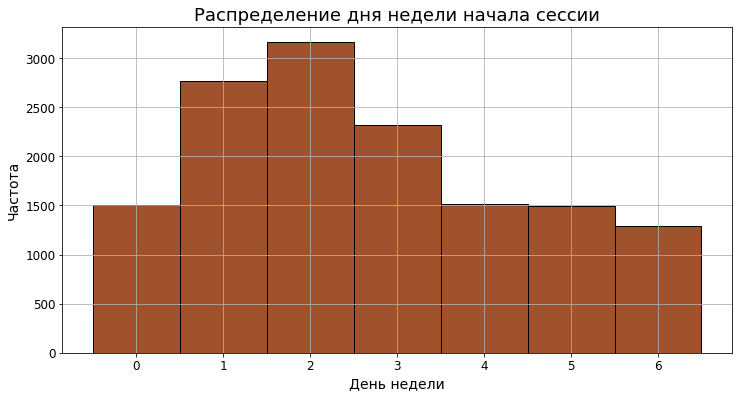

In [22]:
plt.figure(figsize = (12,6))
data = [elem for elem in train_data_10users['day_of_week']]
n, bins, patches = plt.hist(data, bins = list(range(8)), color = 'sienna', edgecolor='black', align = 'left')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('День недели', fontsize = 14)
plt.ylabel('Частота', fontsize = 14)
plt.title('Распределение дня недели начала сессии', fontsize = 18)
plt.grid(True)
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

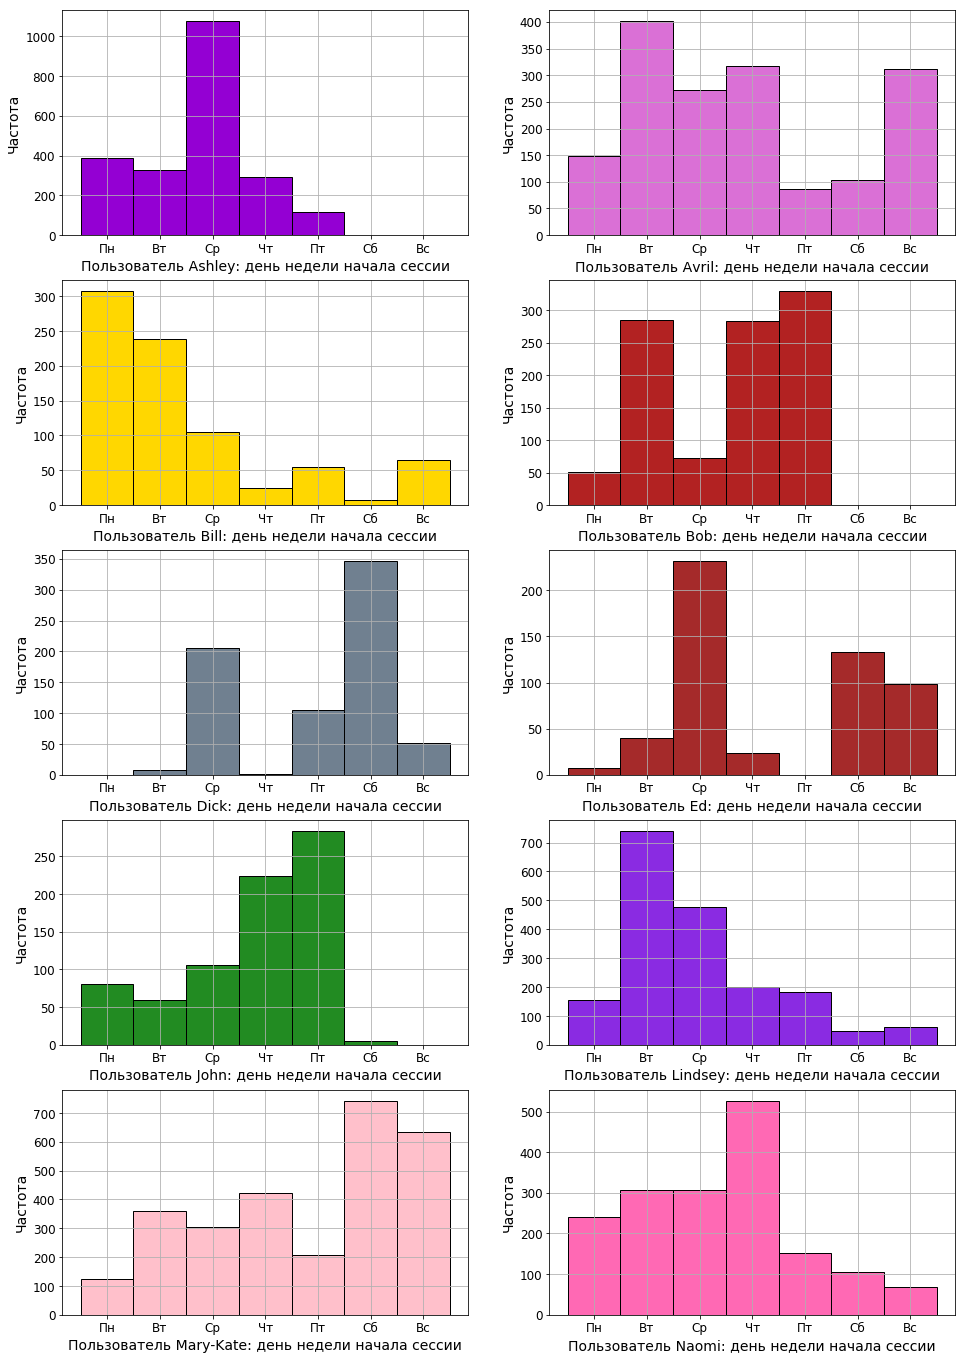

In [23]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (16, 24))
for idx, (user, sub_df) in enumerate(pd.groupby(train_data_10users, 'target')): 
    data = [elem for elem in sub_df['day_of_week']]
    plt.subplot(5,2,idx+1)
    plt.hist(data, bins = list(range(8)), color = color_dic[user], edgecolor='black', align = 'left')
    plt.xticks(list(range(7)), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Пользователь ' + user + ': день недели начала сессии', fontsize = 14)
    plt.ylabel('Частота', fontsize = 14)
    plt.grid(True)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

`Ashley` Не ограничивается несколькими сайтами. Пики приходятся на утро и день. Заходит только в рабочие дни и, основном, в среду.

`Avril` Чаще не ограничивается несколькими сайтами. Пики приходятся на день и вечер. Заходит каждый день.

`Bill` Не ограничивается несколькими сайтами. Пики приходятся на утро и день. Заходит каждый день, но, в основном, в первой половине недели.

`Bob` Чаще не ограничивается несколькими сайтами. Пики приходятся на утро и день. Заходит только в рабочие дни и, в основном, во вторник, четверг и пятницу.

`Dick` Может как ограничиться несколькими сайтами, так и не ограничиться. Заходит в течение всего дня, но не каждый день.

`Ed` Не ограничивается несколькими сайтами. Пик приходится к вечеру. Заходит, в основном, в среду и в выходные.

`John` Не ограничивается несколькими сайтами. Пики приходятся на утро и день. Заходит в рабочие дни, причём чаще перед выходными.

`Lindsey` Не ограничивается несколькими сайтами. Пики приходятся на середину дня. Заходит, в основном, в первой половине недели.

`Mary-Kate` Скорее, ограничится несколькими сайтами. Заходит в течение всего дня и, в основном, в выходные.

`Naomi` Чаще не ограничивается несколькими сайтами. Пик приходится на середину дня. Заходит каждый день.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [24]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as f:
    sites_freq = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [25]:
top10_sites = [k for k in list(sites_freq.keys())[:10]]
top10_freqs = [sites_freq[k][1] for k in list(sites_freq.keys())[:10]]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

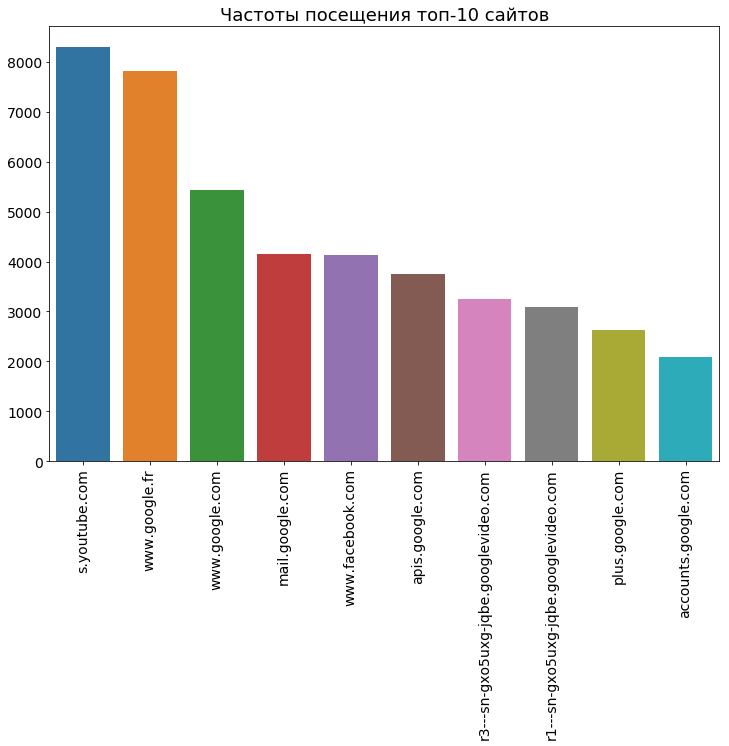

In [26]:
plt.figure(figsize = (12,8))
sns.barplot(x = top10_sites, y = top10_freqs)
plt.xticks(fontsize = 14, rotation = 'vertical')
plt.yticks(fontsize = 14)
plt.title('Частоты посещения топ-10 сайтов', fontsize = 18)
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 